In [407]:
import glob
import doppyo
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [513]:
# Figure rc parameters. See print(plt.rcParams)
figure_rc = {'figure.figsize' : [15.0, 9],
             'axes.titlesize' : 'medium',
             'font.size'      : 20,
             'font.family'    : 'serif'}

# Spin up a cluster

In [3]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(walltime='02:00:00', cores=6, memory='36GB', job_extra=['--qos="express"'])

In [529]:
cluster.start_workers(n=20)

In [530]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://152.83.81.80:37161 Dashboard: http://152.83.81.80:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Read the forecast data

In [349]:
zarr_path = '/scratch1/squ027/data/ecmwf_seas5_precip/19810101-20181201.seas5.ecmwf.daily.australia.228.zarr'

write_to_zarr=False
if write_to_zarr:
    def convert_to_initlead(ds):
        ds = ds.assign_coords(init_date=ds.time[0].values)
        ds['time'] = range(len(ds.time))
        ds = ds.rename({'time':'lead_time'})
        ds.lead_time.attrs['units'] = 'D'
        return ds
        
    nc_path = '/OSM/CBR/OA_DCFP/data1/model_output/ECMWF/forecasts/nc/**/*.seas5.ecmwf.daily.australia.228.nc'
    chunks = {'latitude':-1, 'longitude':-1, 'number':-1}
    nc_paths = sorted(glob.glob(nc_path, recursive=True))[:432] # There is something wrong with some data on 2017-01-01

    ecmwf = xr.open_mfdataset(nc_paths, 
                              concat_dim='init_date', 
                              combine='nested',
                              parallel=True, 
                              preprocess=convert_to_initlead,
                              chunks=chunks)
    ecmwf = ecmwf.chunk(chunks=chunks)
    
    ecmwf.to_zarr(zarr_path, 
                  mode='w',
                  consolidated=True)
    
ecmwf = xr.open_zarr(zarr_path, consolidated=True)['tp']*1000

# Read the observational data

In [350]:
zarr_path = '/scratch1/squ027/data/awap_precip_recal/bom-rain_recal_day-19000101-20180831.zarr'

write_to_zarr=False
if write_to_zarr:
    nc_path = '/OSM/CBR/OA_DCFP/data2/observations/AWAP/nc/rain_recal/day/**/bom-rain_recal_day-*[0-9].nc'
    chunks = {'latitude':-1, 'longitude':-1, 'time':31}
    nc_paths = sorted(glob.glob(nc_path))

    awap = xr.open_mfdataset(nc_paths, 
                             concat_dim='time', 
                             combine='nested',
                             parallel=True, 
                             chunks=chunks)
    awap = awap.chunk(chunks=chunks)
    
    awap.to_zarr(zarr_path, 
                 mode='w',
                 consolidated=True)
    
awap = xr.open_zarr(zarr_path, consolidated=True)['rain_recal_day']

# Average a region around Canberra

In [351]:
box_center_lat = -35.2809
box_center_lon = 149.1300
box_height = 1
box_width = 1

ecmwf_reg = doppyo.utils.get_latlon_region(ecmwf, [box_center_lat-box_height/2,
                                                   box_center_lat+box_height/2,
                                                   box_center_lon-box_width/2,
                                                   box_center_lon+box_width/2]).mean(['latitude',
                                                                                      'longitude'])

awap_reg = doppyo.utils.get_latlon_region(awap, [box_center_lat-box_height/2,
                                                 box_center_lat+box_height/2,
                                                 box_center_lon-box_width/2,
                                                 box_center_lon+box_width/2]).mean(['latitude',
                                                                                    'longitude'])

# Plot a forecast
### "Good" years: 2016-11-01, 2002-11-01

In [497]:
start_date = '2002-05-01'
forecast_date = '2002-09-01'

In [519]:
awap_cum = awap_reg.sel(time=slice(start_date,
                                   pd.to_datetime(forecast_date) + 
                                   pd.DateOffset(days=len(ecmwf.lead_time)-1))).cumsum('time')
shift = awap_cum.sel(time=forecast_date).values

ecmwf_cum = doppyo.utils.leadtime_to_datetime(ecmwf_reg.sel(init_date=forecast_date)+shift)

### Build climatology

In [521]:
awap_clim=[]

first_date = pd.to_datetime(forecast_date) - pd.DateOffset(years=1)
while first_date > pd.to_datetime('1900-01-01'):
    awap_tmp = awap_reg.sel(time=slice(first_date,
                                       pd.to_datetime(first_date) + 
                                       pd.DateOffset(days=len(ecmwf.lead_time)-1))).cumsum('time')+shift
    awap_tmp['time'] = range(len(awap_tmp.time))
    awap_clim.append(awap_tmp)
    
    first_date = first_date - pd.DateOffset(years=1)
    
awap_clim = xr.concat(awap_clim, dim='number').compute()
awap_clim['time'] = pd.date_range(forecast_date, pd.to_datetime(forecast_date) + pd.DateOffset(days=len(ecmwf.lead_time)-1), freq='D')

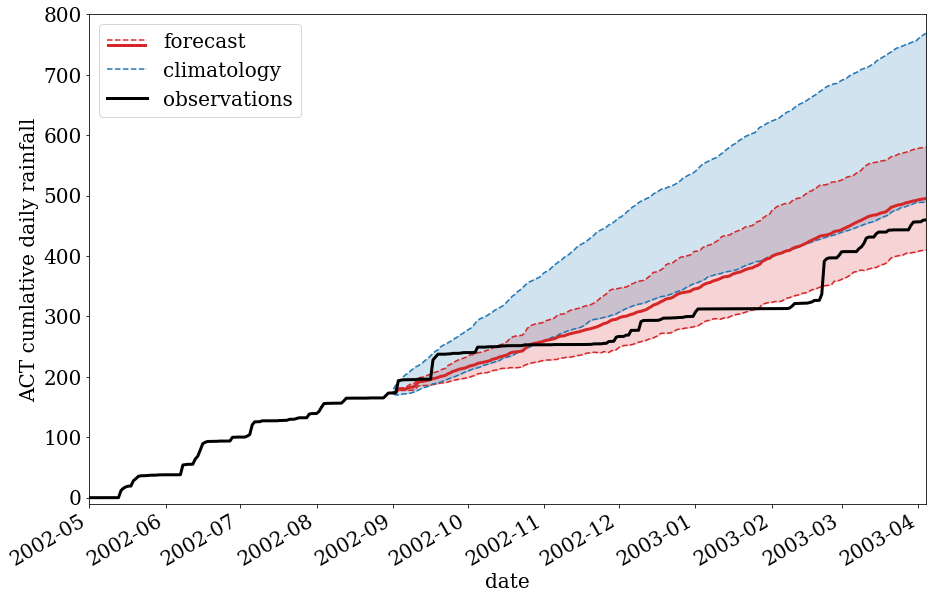

In [542]:
with mpl.rc_context(rc=figure_rc):
    fcst_color='C3'
    obs_color='C0'
    plt.fill_between(ecmwf_cum.time.values, 
                 (ecmwf_cum.mean('number') - ecmwf_cum.std('number')),
                 (ecmwf_cum.mean('number') + ecmwf_cum.std('number')),
                 alpha=0.2,
                 color=fcst_color, label='_nolegend_')
    (ecmwf_cum.mean('number') - ecmwf_cum.std('number')).plot(color=fcst_color,linestyle='--', label='_nolegend_')#, linewidth=1)
    (ecmwf_cum.mean('number') + ecmwf_cum.std('number')).plot(color=fcst_color,linestyle='--', label='forecast')#, linewidth=1)
    plt.fill_between(awap_clim.time.values, 
                 (awap_clim.mean('number') - awap_clim.std('number')),
                 (awap_clim.mean('number') + awap_clim.std('number')),
                 alpha=0.2,
                 color=obs_color, label='_nolegend_')
    (awap_clim.mean('number') - awap_clim.std('number')).plot(color=obs_color,linestyle='--', label='_nolegend_')#, linewidth=1)
    (awap_clim.mean('number') + awap_clim.std('number')).plot(color=obs_color,linestyle='--', label='climatology')#, linewidth=1)
    ecmwf_cum.mean('number').plot(color=fcst_color, linewidth=3, label='_nolegend_')
    awap_cum.plot(color='k', linewidth=3, label='observations')
    
    plt.xlabel('date')
    plt.ylabel('ACT cumlative daily rainfall')
    plt.xlim('2002-05','2003-04-04')
    plt.ylim(-10, 800)
    plt.legend(loc='upper left')
    plt.plot([pd.to_datetime('2002-05-08 14'),
              pd.to_datetime('2002-05-23 12')],[750,750],color=fcst_color, linewidth=3, label='_nolegend_', zorder=10)
    
    plt.savefig('figures/ACT_cum_daily_rainfall_forecast.png', dpi=600, format='png', bbox_inches='tight')